# Simple example


In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [2]:
era5 = xr.open_dataset('../data/smallsampledata-era5.nc')

In [3]:
glofas = xr.open_dataset('../data/smallsampledata-glofas.nc')

Its datatype is `xarray.Dataset`, containing a spatio-temporal subset of 5 variables that we selected from the original ERA5 dataset. It also contains one derived variable (`rtp_500-850`) that is used in Meteorology quite a bit because it is proportional to mass-weighted mean temperature of the air, in this case between 850 and 500 hPa. It could be an additional predictor to classify the weather regime.

In [4]:
era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

To access a variable's description, select one like this:

In [5]:
era5['cp']

<xarray.DataArray 'cp' (time: 5478, latitude: 13, longitude: 25)>
[1780350 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude  (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Attributes:
    standard_name:  lwe_thickness_of_convective_precipitation_amount
    long_name:      Convective precipitation
    units:          m

### Selecting useful predictor variables
The selection has already been done by us when preparing the small sample datasets for you, so you can use them straight away. What is still necessary, is clustering and reshaping the input data dimension, because the dimensionality of the raw input data would be too high: 

To give a rough estimate, imagine using all GloFAS and ERA5 gridpoints of the upstream area of one point. For 1.5x1.5  degree (lat,lon), ERA5 provides 6 x 6 and GloFAS 15 x 15 gridpoints. To take the time dimension into account we'd need, say, 10 days of discharge and 180 days of precipitation. 

Summing up, this makes the raw input dimensionality 15 x 15 x 10 and 6 x 6 x 180, in total ~8700 features, where most of the predictors won't vary that much from one gridpoint to another in the upstream area (large scale temperature, total-column water vapor).

To work around that, we need to 
  1. spatially aggregate  and 
  2. temporally aggregate the data (reduce dimensionality). 
  
Both will be done in sections below, but first we need to define which point we will be making forecasts for.

### Selecting the predictand
The target variable shall be the discharge at the point where the Danube river leaves the data domain. This is given by the point within the catchment where the discharge is the highest, so we first filter by the catchment basin shapefile (Worldbank dataset "Global River Basins")

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


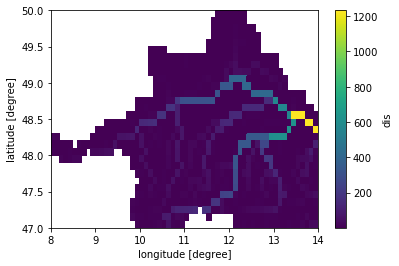

In [6]:
from aux.utils_flowmodel import get_mask_of_basin

dis_mean = glofas['dis'].mean('time')
danube_catchment = get_mask_of_basin(dis_mean)
dis = glofas['dis'].where(danube_catchment)
dis.mean('time').plot()

Now we look up the coordinates of the maximum discharge point. We see that the point of interest is at 48.35 degree latitude and 13.95 degree longitude.

In [7]:
maximum = dis.where(dis==dis.max(), drop=True)
lat, lon = float(maximum.latitude), float(maximum.longitude)
maximum

<xarray.DataArray 'dis' (time: 1, latitude: 1, longitude: 1)>
array([[[4148.968]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 13.95
  * latitude   (latitude) float64 48.35
  * time       (time) datetime64[ns] 1981-07-22
Attributes:
    long_name:  discharge
    units:      m3/s

To double-check, plot a circle around the point of interest. Indeed, its the point we looked for.

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


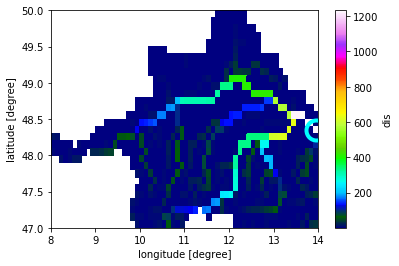

In [8]:
dis.mean('time').plot(cmap='gist_ncar')
plt.gca().plot(lon, lat, color='cyan', marker='o', 
                     markersize=20, mew=4, markerfacecolor='none')

### Spatial aggregation
We can either take the total sum of precipitation that falls throughout the basin, or we can aggregate it by time to the point of interest (POI). As we can see from the discharge plot above, points with less mean discharge are further away from the POI compared to gridpoints with a lighter color. This is the motivation to cluster the precipitation points by the mean discharge of the gridpoint. So we need discharge bins, according to which the precipitation at these gridpoints is grouped together to form one feature/predictor. The bin size can be determined from the distribution of discharges, so that points above 200 m^3/s discharge are one cluster, points from 100-200 m^3/s another cluster and so on.

We'd like to have bins with equal 'flow time' to the POI. 
For 4 equal bins, use percentiles 0.25, 0.5 and 0.75.

Text(0.5, 0, 'discharge [m$^3$/s]')

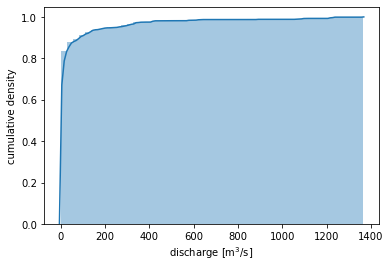

In [9]:
dist = dis_mean.values.ravel()
sns.distplot(dist, hist_kws=dict(cumulative=True),
                   kde_kws=dict(cumulative=True))
plt.ylabel('cumulative density')
plt.xlabel('discharge [m$^3$/s]')

We see that 80 percent of all gridpoints exhibit a mean discharge of less than 20 m^3/s, and that there is a sharp edge between 5 and 10 m^3/s discharge.

Text(0.5, 0, 'discharge [m$^3$/s]')

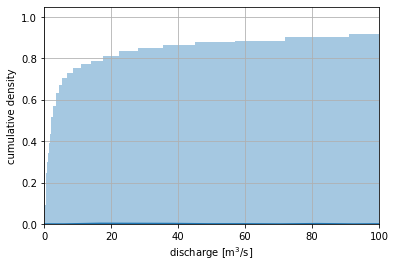

In [10]:
sns.distplot(dist, bins=np.logspace(-1, 4), hist_kws=dict(cumulative=True))
plt.xlim(0,100)
plt.grid()
plt.ylabel('cumulative density')
plt.xlabel('discharge [m$^3$/s]')

In [11]:
for q in [0.25, .5, .75]:
    print('percentile', q, ': ', round(float(dis_mean.quantile(q)),3), 'm^3/s')

percentile 0.25 :  0.8 m^3/s
percentile 0.5 :  2.544 m^3/s
percentile 0.75 :  10.256 m^3/s


In [12]:
bins = [0, 0.8, 2.4, 10.25, 10000]

dis_mean = dis.mean('time')
cluster = dict()
for i in range(len(bins)-1):
    cluster[str(i)] = (dis_mean >= bins[i]) & (dis_mean < bins[i+1])
    cluster[str(i)].attrs['units'] = None
    
cluster = xr.Dataset(cluster, #dims=['cluster', 'latitude', 'longitude'],
                                    coords=dict(clusterId=('clusterId', range(len(bins))),
                                                latitude=('latitude', dis_mean.latitude),
                                                longitude=('longitude', dis_mean.longitude)))
cluster

<xarray.Dataset>
Dimensions:    (clusterId: 5, latitude: 30, longitude: 60)
Coordinates:
  * longitude  (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * clusterId  (clusterId) int64 0 1 2 3 4
Data variables:
    0          (latitude, longitude) bool False False False ... False False
    1          (latitude, longitude) bool False False False ... True False False
    2          (latitude, longitude) bool False False False ... False False
    3          (latitude, longitude) bool False False False ... False True True

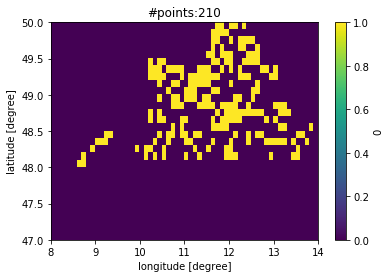

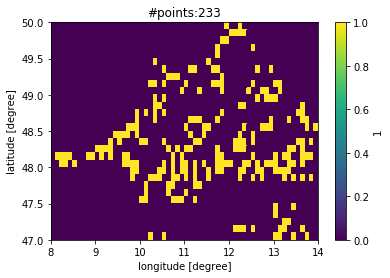

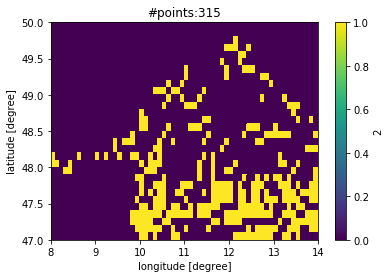

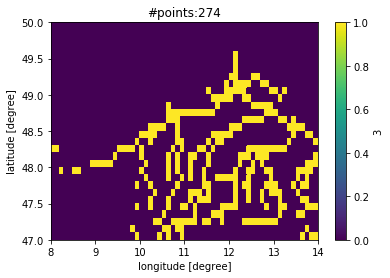

In [13]:
for c in cluster:
    plt.figure()
    cluster[c].plot()
    plt.title('#points:'+str(int(cluster[c].sum())))


To create an image with all clusters in one image, 
we will create a label-array containing a number between 0 and 3 for every gridpoint 
that classifies each gridpoint belonging to one of the four categories. 

In numpy you would probably use the numpy boolean masking operation:
```
for i in range(len(clusters)):
    image[clustering[c]] = i  ```
but you would notice an `IndexError`, as xarray does not support 2-dimensional boolean indexing. So we have to formulate it this way: `image = image.where(~clustering[c], i)`, where not 'this cluster', do nothing, else overwrite with the cluster index

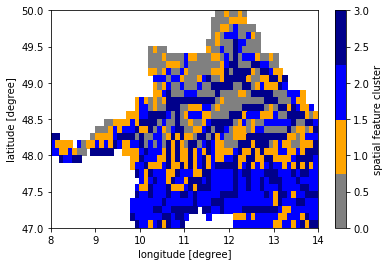

In [14]:
image = dis_mean*0.
image.name = 'spatial feature cluster'
for i, c in enumerate(cluster):
    image = image.where(~cluster[c], i)
    
image.plot(cmap = mpl.colors.ListedColormap(['grey', 'orange', 'blue', 'darkblue']))

These are the gridpoints that are aggregated together to form one precipitation feature for the forecast model. For precipitation that is older than a few days, only the first cluster is of interest. Precipitation that occured on the other gridpoints is already transported outside of the domain for sure.


### Finally prepare all input data


In [15]:
cluster = cluster.to_array('clusterId')
cluster.coords 

Coordinates:
  * longitude  (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * clusterId  (clusterId) <U1 '0' '1' '2' '3'

In [16]:
era5 = era5.interp(latitude=glofas.latitude, longitude=glofas.longitude)

In [17]:
def calc_area(da, resolution_degrees=None):
    km_deg = 111319 # meters per degree latitude
    
    if not resolution_degrees:
        if (len(da.latitude)<2 or len(da.longitude)<2):
            raise ValueError('Either lat or lon is singleton, cannot infer resolution,' \
                             'pass `resolution_degrees` to continue!')
        res_lat = abs(da.latitude[0].values-da.latitude[1].values)
        res_lon = abs(da.longitude[0].values-da.longitude[1].values) 
    else:
        res_lat = resolution_degrees
        res_lon = resolution_degrees
        
    lats = da.latitude.values[:,np.newaxis]*np.ones(len(da.longitude))
    dx = km_deg*abs(np.cos(lats/90))*res_lon
    dy = km_deg*res_lat
    for var in da:
        area = dx*dy
        area = xr.DataArray(area, dims=['latitude', 'longitude'],
                            coords=dict(latitude=('latitude', da.latitude),
                                        longitude=('longitude', da.longitude)))
        area.name = 'area'
        area.attrs['units'] = 'meters'
        return area  # square meters very approximately

def nandot(a, b, **kwargs):
    """Treat NaNs as zeros in dot."""
    a = a.where(~np.isnan(a), other=0.)
    b = b.where(~np.isnan(b), other=0.)
    s = xr.dot(a,b, **kwargs)
    return s #s.where(~np.isnan(s), other=0.).sum(dims)  # other=0. replaces NaN by 0.

In [21]:
area_per_gridpoint = calc_area(dis_mean)

features = []
for var in ['cp', 'lsp']:
    for cluster_id in cluster.clusterId:
        points = era5[var].where(cluster.sel(clusterId=cluster_id))
        feature = nandot(points, area_per_gridpoint)

        # as we will combine the arrays as variables in a xr.Dataset, 
        # we move the cluster information from coordinates to the array name
        cluster_id = str(feature.clusterId.values)
        feature = feature.drop('clusterId')
        feature.name = var+'_cluster'+str(cluster_id)
        features.append(feature)

In [22]:
X = xr.merge(features)
X

<xarray.Dataset>
Dimensions:       (time: 5478)
Coordinates:
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    cp_cluster0   (time) float64 5.482e+07 1.906e+07 7.959e+07 ... 0.0 7.634e+05
    cp_cluster1   (time) float64 6.716e+07 2.49e+07 ... 2.774e+05 5.396e+05
    cp_cluster2   (time) float64 1.021e+08 3.952e+07 ... 1.39e+06 1.192e+06
    cp_cluster3   (time) float64 8.35e+07 3.462e+07 ... 6.164e+05 5.767e+05
    lsp_cluster0  (time) float64 4.996e+07 2.12e+08 ... 7.971e+06 1.25e+06
    lsp_cluster1  (time) float64 7.006e+07 2.711e+08 ... 1.043e+07 1.295e+07
    lsp_cluster2  (time) float64 1.308e+08 4.153e+08 ... 9.562e+06 5.657e+07
    lsp_cluster3  (time) float64 8.867e+07 3.254e+08 ... 7.407e+06 2.891e+07

In [23]:
def add_shifted_predictors(ds, shifts, variables='all'):
    """Adds additional variables to an array which are shifted in time.
    
    Parameters
    ----------
    ds : xr.Dataset
    shifts : list of integers
    variables : str or list
    """
    if variables == 'all': 
        variables = ds.data_vars
        
    for var in variables:
        for i in shifts:
            if i == 0: continue  # makes no sense to shift by zero
            newvar = var+'-'+str(i)
            ds[newvar] = ds[var].shift(time=i)
    return ds

What is shifting?

In [24]:
shifts = [1, 2, 3]
shift_vars = ['lsp'] 

Xs = add_shifted_predictors(era5, shifts, variables=shift_vars)

In [25]:
Xs

<xarray.Dataset>
Dimensions:      (latitude: 30, longitude: 60, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * latitude     (latitude) float64 49.95 49.85 49.75 ... 47.25 47.15 47.05
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
Data variables:
    cp           (time, latitude, longitude) float64 0.002164 ... 0.0003907
    lsp          (time, latitude, longitude) float64 0.001295 ... 0.005143
    swvl1        (time, latitude, longitude) float64 0.3792 0.378 ... 0.3357
    tcwv         (time, latitude, longitude) float64 8.601 8.688 ... 9.349 9.539
    ro           (time, latitude, longitude) float64 1.07e-05 ... 2.108e-05
    rtp_500-850  (time, latitude, longitude) float64 3.931e+04 ... 4.02e+04
    lsp-1        (time, latitude, longitude) float64 nan nan ... 6.809e-05
    lsp-2        (time, latitude, longitude) float64 nan nan ... 0.0002988
    lsp-3        (time, latitude, longitude) float64 

### The goal
The goal shall be to aggregate over an increasing number of days as we iterate back in time.

In [26]:
def shift_and_aggregate(df, shift, aggregate):
    """
    To get a predictor from [lsp(t-3), ..., lsp(t-6)],
    use shift = 3 and aggregate = 3
    """
    return df.shift(time=shift).rolling(time=aggregate).sum()/aggregate

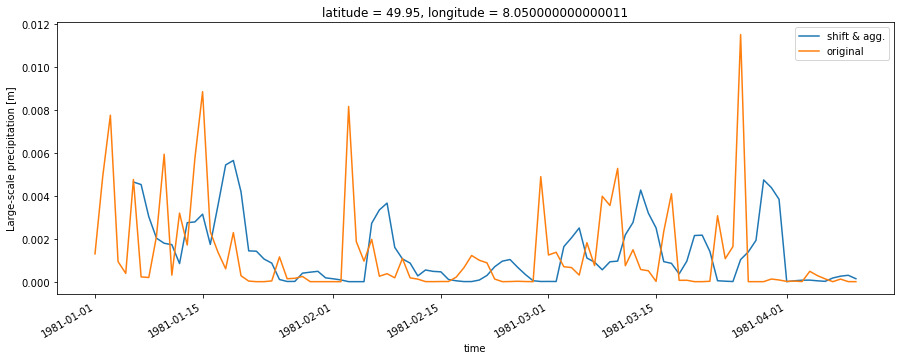

In [27]:
# last 3 days as a single predictor
last3 = shift_and_aggregate(Xs['lsp'], shift=3, aggregate=3)

fig, ax = plt.subplots(figsize=(15,5))
last3[:100, 0,0].plot(ax=ax, label='shift & agg.')
Xs['lsp'][:100,0,0].plot(ax=ax, label='original')
ax.legend()

In [30]:
# numerical test
t = 5
t_shift = t-3
manual_shift_agg = (Xs['lsp'][t_shift,0,0] 
                    + Xs['lsp'][t_shift-1,0,0] 
                    + Xs['lsp'][t_shift-2,0,0])/3

print('pandas returned  ', float(last3[t,0,0]))
print('manual test      ', float(manual_shift_agg))
print('test case success', np.allclose(manual_shift_agg, last3[t,0,0]))

pandas returned   0.004649092154577375
manual test       0.004649092154577375
test case success True


In [31]:
# actual predictors
Xs['lsp-4-10'] = shift_and_aggregate(Xs['lsp'], shift=4, aggregate=7)
Xs['lsp-11-24'] = shift_and_aggregate(Xs['lsp'], shift=14, aggregate=14)
Xs['lsp-25-54'] = shift_and_aggregate(Xs['lsp'], shift=28, aggregate=30)

In [32]:
Xs

<xarray.Dataset>
Dimensions:      (latitude: 30, longitude: 60, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * latitude     (latitude) float64 49.95 49.85 49.75 ... 47.25 47.15 47.05
  * longitude    (longitude) float64 8.05 8.15 8.25 8.35 ... 13.75 13.85 13.95
Data variables:
    cp           (time, latitude, longitude) float64 0.002164 ... 0.0003907
    lsp          (time, latitude, longitude) float64 0.001295 ... 0.005143
    swvl1        (time, latitude, longitude) float64 0.3792 0.378 ... 0.3357
    tcwv         (time, latitude, longitude) float64 8.601 8.688 ... 9.349 9.539
    ro           (time, latitude, longitude) float64 1.07e-05 ... 2.108e-05
    rtp_500-850  (time, latitude, longitude) float64 3.931e+04 ... 4.02e+04
    lsp-1        (time, latitude, longitude) float64 nan nan ... 6.809e-05
    lsp-2        (time, latitude, longitude) float64 nan nan ... 0.0002988
    lsp-3        (time, latitude, longitude) float64 

In [33]:
y = era5['lsp'].interp(latitude=lat, longitude=lon)
y

<xarray.DataArray 'lsp' (time: 5478)>
array([2.177159e-03, 7.378675e-03, 1.861530e-02, ..., 1.649513e-06,
       1.006345e-06, 5.271745e-05])
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude   float64 48.35
    longitude  float64 13.95
Attributes:
    standard_name:  lwe_thickness_of_stratiform_precipitation_amount
    long_name:      Large-scale precipitation
    units:          m

In [34]:
Xar = Xs.to_array(dim='features')
yar = y #.to_array()
#yar = yar.rename({'variable': 'features'})
yar = yar.drop(['latitude', 'longitude'])

In [35]:
Xy = xr.concat([Xar, yar], dim='features')  
Xyt = Xy.dropna('time', how='any')  # drop them as we cannot train on nan values

KeyError: 'latitude'

In [ ]:
Xy.shape

In [ ]:
assert len(Xyt.time) > 1

In [ ]:
predictand = 'dis'
predictors = [v for v in Xyt.coords['features'].values if v != predictand]

In [ ]:
Xda = Xyt.loc[predictors]
yda = Xyt.loc[predictand]

In [ ]:
predictors

In [ ]:
time = yda.time
Xda = Xda.chunk(dict(time=-1, features=-1)).data.T
yda = yda.data.squeeze()

In [ ]:
Xda

In [ ]:
yda

In [ ]:
import joblib
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

#from dask_ml.xgboost import XGBRegressor
from dask_ml.linear_model import LogisticRegression
from dask_ml.linear_model import LinearRegression


In [ ]:
model_kws = dict(n_jobs=-1, max_iter=10000, verbose=True)

pipe = Pipeline([('scaler', StandardScaler()),
                 #('pca', PCA(n_components=6)),
                 ('model', LinearRegression(**model_kws)),],
                verbose=True)

In [ ]:
pipe

In [ ]:
Xda = Xda.persist()

with ProgressBar():
    pipe.fit(Xda, yda)

In [ ]:
def add_time(vector, time, name=None):
    """Converts arrays to xarrays with a time coordinate."""
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)

In [ ]:
with ProgressBar():
    ytest = pipe.predict(Xda)

In [ ]:
ytest = add_time(ytest, time, name='dis-forecast')

In [ ]:
fig, ax = plt.subplots(figsize=(24,5))
Xyt.loc[predictand].to_pandas().plot(ax=ax, label='dis-reanalysis')
ytest.to_pandas().plot(ax=ax, label='dis-forecast')
plt.legend()
ax.set_ylabel('river discharge [m$^3$/s]')